In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.collections import PatchCollection
from scipy.optimize import curve_fit
Z = 16

In [2]:
covid = pd.read_csv("Coronavirus_Italy.csv")

In [3]:
covid.head()

,Date,Infected,Dead,Recovered,Total
0,2/24/2020,221,7,1,229
1,2/25/2020,309,11,1,321
2,2/26/2020,385,12,3,400
3,2/27/2020,588,17,45,650
4,2/28/2020,821,21,45,887


In [4]:
covid.tail()

,Date,Infected,Dead,Recovered,Total
21,3/16/2020,23073,2158,2749,27980
22,3/17/2020,26062,2503,2941,31506
23,3/18/2020,28710,2978,4025,35713
24,3/19/2020,33190,3405,4440,41035
25,3/20/2020,37860,4032,5129,47021


In [5]:
covid.iloc[14]

Date         3/9/2020
Infected         7985
Dead              463
Recovered         724
Total            9172
Name: 14, dtype: object

In [7]:
def beta_t(t, b_step1, b_step2, alpha1, alpha2, dead, kappa, N=N0):
    if t <= 14:
        beta0 = b_step1
        alpha = alpha1
    else:
        beta0 = b_step2
        alpha = alpha2
    return beta0*(1-alpha)*(1-dead/N)**kappa

In [8]:
def S_der(S, beta, I, N=N0, mu=0):
    return -beta*S*I/N-mu*S

def E_der(E, beta, S, I, sigma=sigma, N=N0, mu=0):
    return beta*S*I/N-(sigma+mu)*E

def I_der(I, E, gamma=gamma, sigma=sigma, mu=0):
    return sigma*E-(gamma+mu)*I

def R_der(R, I, gamma=gamma, mu=0):
    return gamma*I-mu*R

def N_der(N=N0, mu=0):
    return -mu*N

def D_der(D, I, lamb, gamma=gamma, d=ds):
    return d*gamma*I-lamb*D

def C_der(C, E, sigma=sigma):
    return sigma*E

In [9]:
def euler(now, der_func, dh, *args):
    return now + dh*der_func(now, *args)

<ErrorbarContainer object of 3 artists>

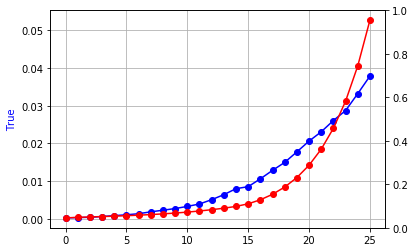

In [35]:
def pred_infected(times, b_step1, b_step2, alpha1, alpha2, kappa, lamb):
    all_S, all_E, all_I, all_R, all_D, all_C = [S0], [E0], [I0], [R0], [D0], [C0]
    #b_step1 = 0.6
    #b_step2 = 1.6
    #alpha1 = 0
    #alpha2 = 0.4
    #kappa = 1000
    #lamb = 11
    integration_times = np.arange(0, times[-1]+dh, dh)
    infected = []
    for i, time in enumerate(integration_times):    
        beta = beta_t(time, b_step1, b_step2, alpha1, alpha2, all_D[i], kappa)
        new_S = euler(all_S[i], S_der, dh, beta, all_I[i])
        new_E = euler(all_E[i], E_der, dh, beta, all_S[i], all_I[i])
        new_I = euler(all_I[i], I_der, dh, all_E[i])
        new_R = euler(all_R[i], R_der, dh, all_I[i])
        new_D = euler(all_D[i], D_der, dh, all_I[i], lamb)
        new_C = euler(all_C[i], C_der, dh, all_E[i])

        all_S.append(new_S)
        all_E.append(new_E)
        all_I.append(new_I)
        all_R.append(new_R)
        all_D.append(new_D)
        all_C.append(new_C)
        
        if time in times:
            infected.append(new_I)
    infected = np.array(infected)
    return infected

In [36]:
N0 = 60.48
S0 = 0.868*N0
E0 = 2.8*covid['Infected'][0]/10**6
I0 = covid['Infected'][0]/10**6
R0 = (covid['Dead'][0] + covid['Recovered'][0])/10**6
D0 = covid['Dead'][0]/10**6
C0 = covid['Total'][0]/10**6
sigma = 1/3.
gamma = 1/5.
ds = 0.1
dh = 0.05 #integration timestep (days)   

In [12]:
p0 = (0.5944, 1.68, 0.4239, 0.8478, 1117.3, 11.2)
p0 = (0.6, 1.6, 0, 0.4, 1000, 11)
popt, pcov = curve_fit(pred_infected, covid.index.values, covid['Infected']/10**6, p0=p0)
#smooth_times = np.arange(0, covid.index.values[-1], dh)
#y_fit = pred_infected(smooth_times, *popt)
#plt.plot(smooth_times, y_fit)
fig = plt.figure()
ax = plt.axes()
ax.grid()
ax2 = ax.twinx()
xx = np.linspace(0,25,26)
ax.errorbar(covid.index, covid['Infected']/10**6, fmt='o-', color='b')
ax.set_ylabel("True")
ax.yaxis.label.set_color('b')
ax.errorbar(xx, pred_infected(xx, *p0), fmt='o-', color='r')
#ax2.set_ylabel("Predicted")
#ax2.yaxis.label.set_color('r')

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25], dtype=int64)